# Example of storing results to different format for ImageToTextV2

This notebook demonstrate pipeline for detect text using __ImageTextDetectorV2__ and text recognition using __ImageToTextV2__ on the image.

__ImageToTextV2__ support following output formats:
* OcrOutputFormat.TEXT - raw unformatted text
* OcrOutputFormat.FORMATTED_TEXT - text with preserved original formatting
* OcrOutputFormat.HOCR - [HOCR specification](http://kba.cloud/hocr-spec/1.2/#introduction)

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.11/"
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""


import os
if AWS_ACCESS_KEY_ID != "":
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license

In [2]:
# install from PYPI using secret
%pip install torch
%pip install transformers==4.16.2
%pip install spark-ocr==$version+spark32 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.johnsnowlabs.com/4.0.0-49cdb09f66ca01a93f959366f0e4a84d1a09b2df


In [3]:
#%pip install ../../../python/dist/spark-ocr-3.11.1+spark30.tar.gz

## Initialization of spark session

In [4]:
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path)

spark

Spark version: 3.2.1
Spark NLP version: 4.0.0
Spark OCR version: 4.0.0



# Read image and display it

In [5]:
import pkg_resources
import pyspark.sql.functions as f
from pyspark.ml import PipelineModel
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images


    Image #0:
    Origin: file:/usr/local/lib/python3.7/dist-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


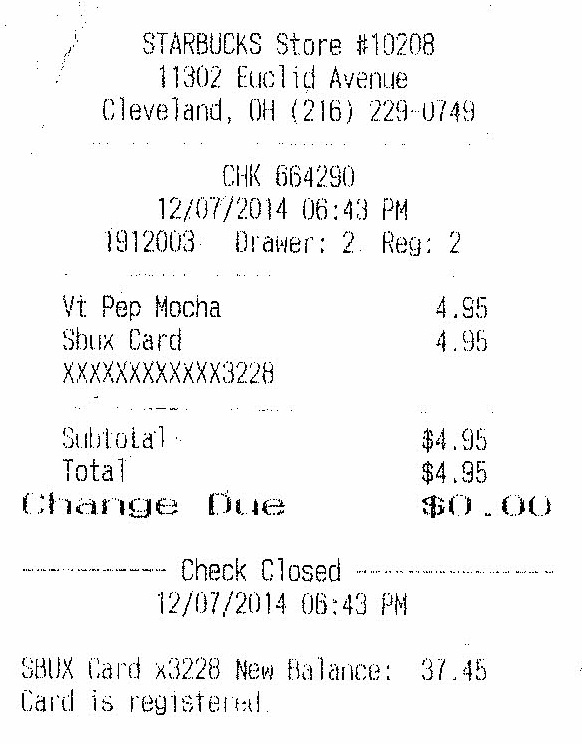

In [6]:
imagePath = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/check.jpg')
image_df = spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().setImageType(ImageType.TYPE_3BYTE_BGR).transform(image_df), "image")

# Define OCR Pipeline for detect and recognize text 

In [7]:
binary_to_image = BinaryToImage() 
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setWithRefiner(False) \
    .setLinkThreshold(0.3)

ocr = ImageToTextV2.pretrained("ocr_small_printed", "en", "clinical/ocr") \
    .setInputCols(["image", "text_regions"]) \
    .setOutputCol("text") \
    .setOutputFormat(OcrOutputFormat.TEXT) \
    .setLineTolerance(0) \
    .setGroupImages(False)

ocr_formatted = ImageToTextV2.pretrained("ocr_small_printed", "en", "clinical/ocr") \
    .setInputCols(["image", "text_regions"]) \
    .setOutputCol("text_formatted") \
    .setOutputFormat(OcrOutputFormat.FORMATTED_TEXT) \
    .setLineTolerance(0) \
    .setGroupImages(False) 

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green) \
    .setRotated(True)

pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    ocr,
    ocr_formatted,
    draw_regions
])

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB
ocr_small_printed download started this may take some time.
Approximate size to download 139.9 MB
ocr_small_printed download started this may take some time.
Approximate size to download 139.9 MB


# Run pipeline and show results

### Show detected text on the original image


    Image #0:
    Origin: file:/usr/local/lib/python3.7/dist-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


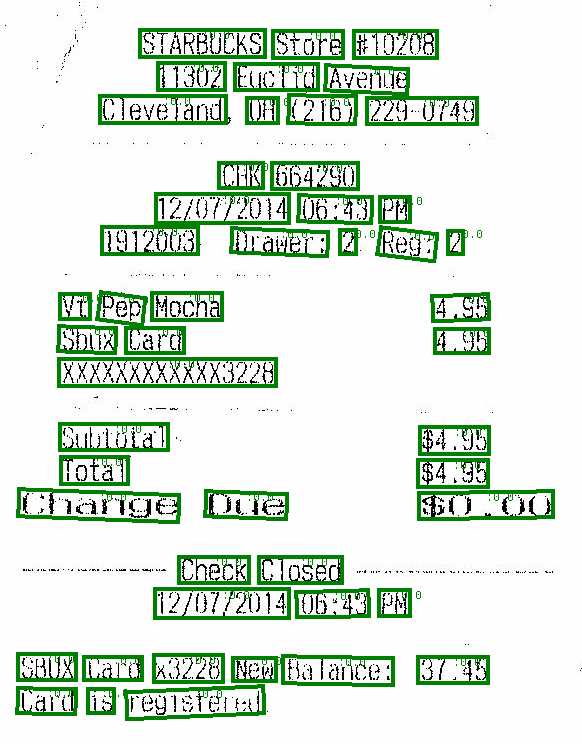

In [8]:
result = pipeline.transform(image_df).cache()
display_images(result, "image_with_regions")

### Unformatted results

In [9]:
print(("").join([x.text for x in result.select("text").collect()]))

STARBUCKS STORE #10208
11302 EUCLID AVENUE
CLEVELAND OH (216) 229-0749
CHK 664290
12/07/2014 06:43 PM
1912003 DRAMER: 2 REG: 2
VT PEP MOCHA 4.95
SBUX CARD 4.95
XXXXXXXXXXXX3228
SUBTOTAL $4.95
TOTAL $4.95
CHANGE DUE $0.00
CHECK CLOSED
12/07/2014 06:43 PM
SBUX CARD X3228 NEW BALANCE: 37.45
CARD IS REGISTERED


### Formatted results

In [10]:
print(("").join([x.text_formatted for x in result.select("text_formatted").collect()]))

          STARBUCKS  STORE #10208
            11302 EUCLID AVENUE
       CLEVELAND  OH  (216) 229-0749

                CHK 664290
           12/07/2014 06:43  PM
       1912003   DRAMER:  2  REG: 2

    VT PEP MOCHA                 4.95
    SBUX CARD                    4.95
    XXXXXXXXXXXX3228

    SUBTOTAL                    $4.95
    TOTAL                       $4.95
 CHANGE        DUE              $0.00

             CHECK CLOSED
           12/07/2014 06:43  PM

 SBUX CARD X3228 NEW BALANCE:   37.45
 CARD IS REGISTERED


### Define pipeline for recognize text and get results in HOCR format

In [11]:
binary_to_image = BinaryToImage() 
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setWithRefiner(False) \
    .setSizeThreshold(15) \
    .setLinkThreshold(0.3)

ocr = ImageToTextV2.pretrained("ocr_small_printed", "en", "clinical/ocr") \
    .setInputCols(["image", "text_regions"]) \
    .setOutputCol("hocr") \
    .setOutputFormat(OcrOutputFormat.HOCR) \
    .setGroupImages(False) 

tokenizer = HocrTokenizer() \
    .setInputCol("hocr") \
    .setOutputCol("token") \

draw_annotations = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("token") \
    .setOutputCol("image_with_annotations") \
    .setFilledRect(False) \
    .setFontSize(14) \
    .setRectColor(Color.red)

hocr_pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    ocr,
    tokenizer,
    draw_annotations
])

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB
ocr_small_printed download started this may take some time.
Approximate size to download 139.9 MB


### Draw HOCR to the original image


    Image #0:
    Origin: file:/usr/local/lib/python3.7/dist-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


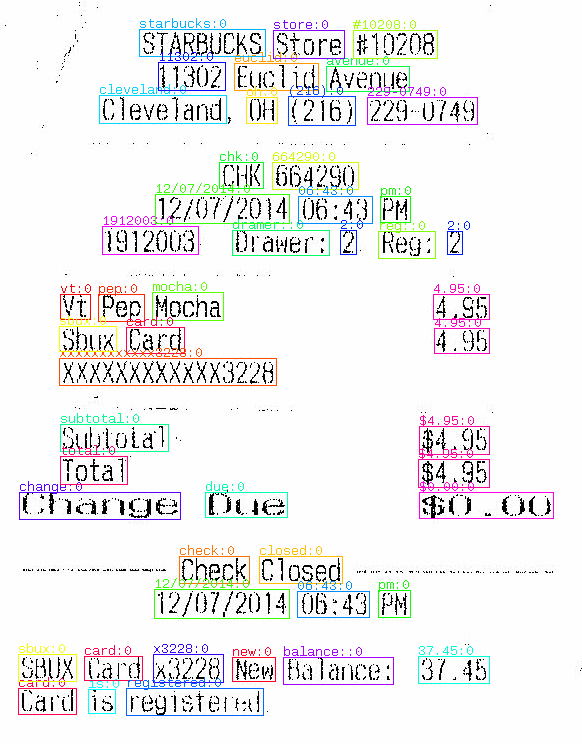

In [12]:
hocr_result = hocr_pipeline.transform(image_df).cache()
display_images(hocr_result, "image_with_annotations", width=1000)

### Show raw HOCR

In [13]:
print(hocr_result.select("hocr").collect()[0].hocr)

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">
  <head>
    <title></title>
    <meta http-equiv="Content-Type" content="text/html;charset=utf-8" />
    <meta name='ocr-system' content='Spark OCR' />
    <meta name='ocr-langs' content='en' />
    <meta name='ocr-number-of-pages' content='1' />
    <meta name='ocr-capabilities' content='ocr_page ocr_carea ocr_line ocrx_word ocrp_lang'/>
  </head>
  <body>
    <div class='ocr_page' lang='en' title='bbox 0 0 553 715'>
        <div class='ocr_carea' lang='en' title='bbox 18 29 553 715'>
            <span class='ocr_line' id='line_0' title='bbox 139 29 437 58; baseline 0 -5'>
                <span class='ocrx_word' id='word_0_0' title='bbox 139 29 265 56'>STARBUCKS</span>
                <span class='ocrx_word' id='word_0_1' title='bbox 273 30 344 58'>STORE</spa